In [1]:
from __future__ import print_function, division

plot_to_pdf = False

if plot_to_pdf:
    import matplotlib as mpl
    mpl.use('pdf')
    
    import matplotlib.pyplot as plt
    
    plt.rc('font', family='serif', serif='Times')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=8) # 10
    plt.rc('ytick', labelsize=8) # 10
    plt.rc('axes', labelsize=8) # 10
    plt.rc('legend', fontsize=8) # 10
    title_font_size = 8
    data_font_size = 8
else:
    import matplotlib.pyplot as plt
    
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import time

from copy import deepcopy

%matplotlib inline

In [2]:
colors = {}
colors['green']   = ( 41/255.,  89/255.,  57/255., 1.0) # green
colors['brown']   = ( 67/255.,  53/255.,  32/255., 1.0) # brown
colors['blue']    = ( 35/255., 104/255., 155/255., 1.0) # blue
colors['purple']  = (114/255., 106/255., 149/255., 1.0) # purple
colors['red']     = (236/255.,  70/255.,  70/255., 1.0) # red
colors['orange'] = (226/255., 120/255.,   2/255., 1.0) # orange

In [3]:
data = np.load('cartpole_policies_analytic_from_random_50.npz')
control_trajectories = data['control_trajectories']
state_trajectories = data['state_trajectories'][:,:,:]

print(control_trajectories.shape, state_trajectories.shape)

subsampling_step_one = 2
control_trajectories = control_trajectories[::subsampling_step_one,:,:]
state_trajectories = state_trajectories[::subsampling_step_one,:,:]
print(control_trajectories.shape, state_trajectories.shape)

sample_dim = state_trajectories.shape[0]
state_dim = state_trajectories.shape[1]
time_dim = state_trajectories.shape[2]

(415, 49, 1) (415, 4, 50)
(208, 49, 1) (208, 4, 50)


In [4]:
dataset = np.zeros((sample_dim * time_dim, state_dim + 1),dtype=np.double)
print(dataset.shape)
for i in range(sample_dim):
    dataset[i * time_dim:(i+1) * time_dim,0] = state_trajectories[i,0,:].T
    dataset[i * time_dim:(i+1) * time_dim,1] = np.cos(state_trajectories[i,1,:]).T
    dataset[i * time_dim:(i+1) * time_dim,2] = np.sin(state_trajectories[i,1,:]).T
    dataset[i * time_dim:(i+1) * time_dim,3] = state_trajectories[i,2,:].T
    dataset[i * time_dim:(i+1) * time_dim,4] = state_trajectories[i,3,:].T

(10400, 5)


# Initial dataset

## State trajectories (on manifold)

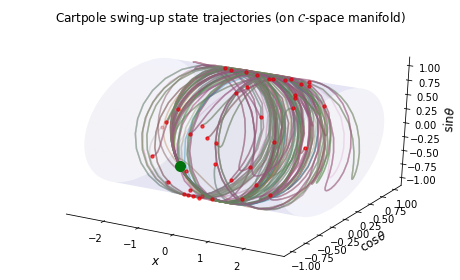

In [5]:
X_plot = dataset

fig = plt.figure()
fig.set_size_inches(6.5, 4.0)
ax = fig.add_subplot(111, projection='3d')

plot_x = state_trajectories[:,0]
r = 1. #X_plot[:,3].reshape(sample_dim,time_dim) + 2.
plot_y = r * np.cos(state_trajectories[:,1])
plot_z = r * np.sin(state_trajectories[:,1])

# Cylinder
x=np.linspace(-1, 1, 100)
z=np.linspace(-1, 1, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(1-Xc**2)

# Draw parameters
rstride = 20
cstride = 10
ax.plot_surface(2.7*Zc, Yc, Xc, alpha=0.05, rstride=rstride, cstride=cstride, color='b')
ax.plot_surface(2.7*Zc, -Yc, Xc, alpha=0.05, rstride=rstride, cstride=cstride, color='b')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

# Samples from start to goal
for s in range(sample_dim):
    ax.plot(plot_x[s,:], plot_y[s,:], plot_z[s,:], alpha=.2)
    ax.scatter(plot_x[s,0], plot_y[s,0], plot_z[s,0], color="r", s=10, alpha=.2)

# Goal on manifold
ax.scatter([0], [-1*r], [0], color="g", s=100, alpha=1.)
 
ax.set_xlabel(r'$x$', fontsize=12)
ax.set_ylabel(r'$\cos\theta$', fontsize=12)
ax.set_zlabel(r'$\sin\theta$', fontsize=12)
plt.title('Cartpole swing-up state trajectories (on $\mathcal{C}$-space manifold)', fontsize=12)

plt.tight_layout()
plt.show()

fig.subplots_adjust(left=-0.1, bottom=0., right=.98, top=1.02) # for 6.5 x 4

plot_to_pdf and fig.savefig('plot/cartpole_swingup_from_random_state_trajectories_on_manifold.pdf')

## State trajectories (original)

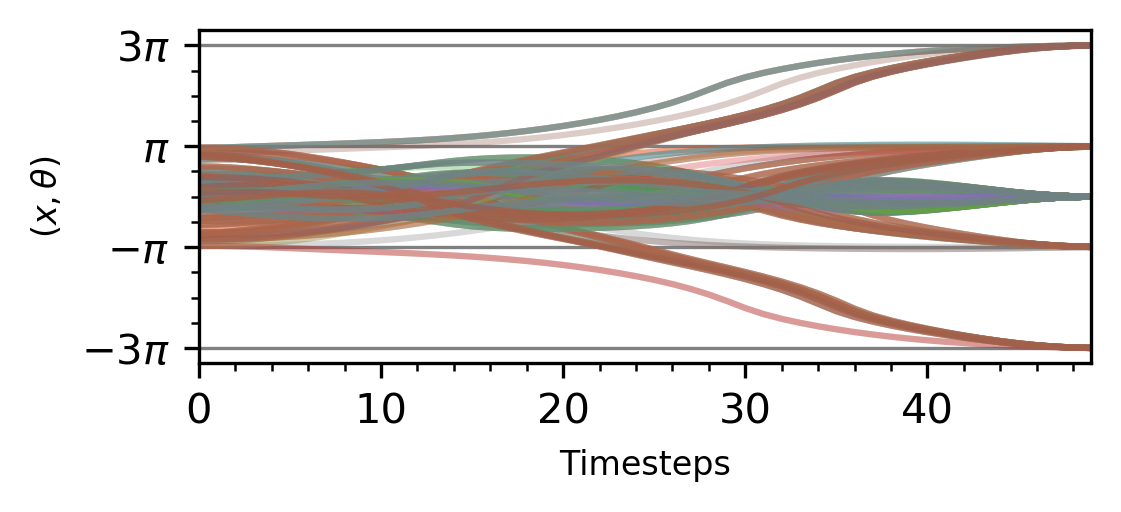

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(3.5, 1.5)
fig.set_dpi(300)

for s in range(sample_dim):
    ax.plot(state_trajectories[s,:2].T, alpha=.3)

ax.set_xlabel(r'Timesteps', fontsize=8)
ax.set_ylabel(r'$(x,\theta)$', fontsize=8)
# plt.title('Cartpole swing-up state trajectories ($\mathcal{C}$-space)', fontsize=12)
plt.xlim(0,time_dim-1)

# ax.set_yticks([-3*np.pi,-2.*np.pi,-np.pi,0,np.pi,2*np.pi,3*np.pi,4*np.pi,5*np.pi])
# ax.set_yticklabels([r'$-3\pi$',r'$-2\pi$',r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$',r'$3\pi$',r'$4\pi$',r'$5\pi$'])

# ax.set_yticks([-2.*np.pi,0,2*np.pi,4*np.pi], minor=True)
# ax.set_yticklabels([r'$-2\pi$',r'$0$',r'$2\pi$',r'$4\pi$'], minor=True)
# ax.set_yticks([-5*np.pi,-3*np.pi,-np.pi,np.pi,3*np.pi,5*np.pi], minor=False)
ax.set_yticks([-3*np.pi,-np.pi,np.pi,3*np.pi], minor=False)
# ax.set_yticklabels([r'$-5\pi$',r'$-3\pi$',r'$-\pi$',r'$\pi$',r'$3\pi$',r'$5\pi$'], minor=False)
ax.set_yticklabels([r'$-3\pi$',r'$-\pi$',r'$\pi$',r'$3\pi$'], minor=False)

plt.grid(axis='y', which='major', color='grey', linestyle='-')

plt.minorticks_on()

plt.tight_layout()

fig.subplots_adjust(left=.14, bottom=0.24, right=.99, top=.98)
# fig.subplots_adjust(left=.1, bottom=0.145, right=.98, top=.93)
# fig.subplots_adjust(left=.1, bottom=0.11, right=.98, top=.93) # for 6.5 x 4

plot_to_pdf and fig.savefig('plot/cartpole_swingup_from_random_state_trajectories_raw.pdf')
plt.show()

## Control trajectories

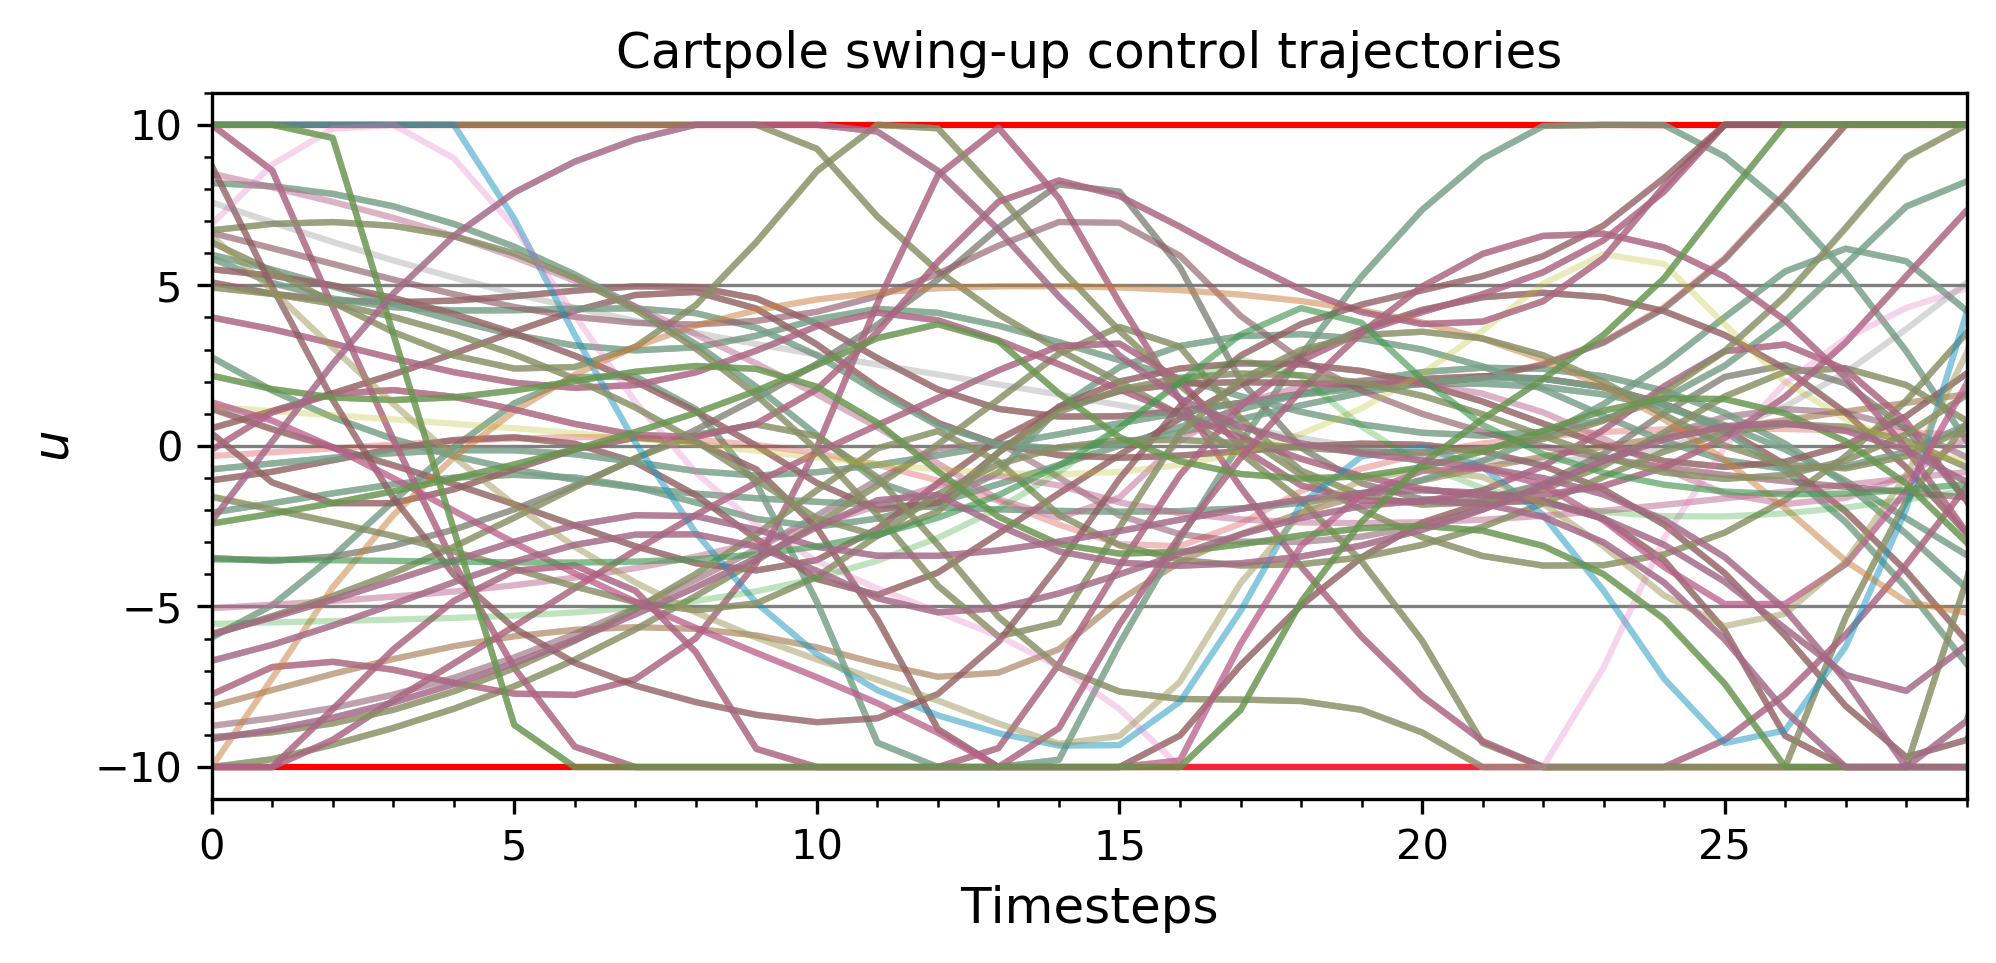

In [7]:
fig, ax = plt.subplots()
# fig.set_size_inches(6.5, 4.0)
fig.set_size_inches(6.5, 3.0)
fig.set_dpi(300)

u_max = 10.

ax.hlines(y=u_max, xmin=0., xmax=time_dim, color='r')
ax.hlines(y=-u_max, xmin=0., xmax=time_dim, color='r')

for s in range(sample_dim):
    ax.plot(control_trajectories[s,:], alpha=.3)

ax.set_xlabel(r'Timesteps', fontsize=12)
ax.set_ylabel(r'$u$', fontsize=12)
plt.title('Cartpole swing-up control trajectories', fontsize=12)
plt.xlim(0,time_dim-21)

plt.grid(axis='y', which='major', color='grey', linestyle='-')

plt.minorticks_on()

plt.tight_layout()

fig.subplots_adjust(left=.08, bottom=0.145, right=.98, top=.93)
# fig.subplots_adjust(left=.1, bottom=0.11, right=.98, top=.93)  # for 6.5 x 4

plot_to_pdf and fig.savefig('plot/cartpole_swingup_from_random_control_trajectories.pdf')
plt.show()

# Homological Groups

In [8]:
result_data = np.load('clustering_result.npz', allow_pickle=True, encoding='bytes')
result = result_data['result'].tolist()
D = result_data['D']
labels = result_data['labels']
state_trajectories = result_data['state_trajectories']
control_trajectories = result_data['control_trajectories']

In [9]:
from topological_memory_clustering.plot import plot_diagrams

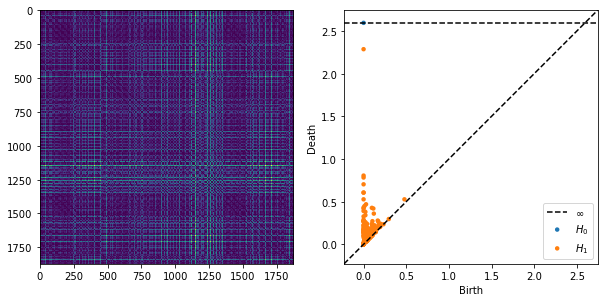

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(D)
# plt.title("Original Distance Matrix: {0:,} Edges".format(resultfull['num_edges']), fontsize=12)

plt.subplot(122)
ax = plot_diagrams(result_data['result'].tolist()['dgms'], show=False)
# ax.set_title("Full Filtration: Elapsed Time %g Seconds" % timefull, fontsize=12)

# TODO add circle

plt.show()
plt.tight_layout()
# plt.savefig('plot/cartpole_swing_up_dense_filtration.pdf')

## Plot classes

### State trajectories on manifold, clustered

In [11]:
assigned_class = labels

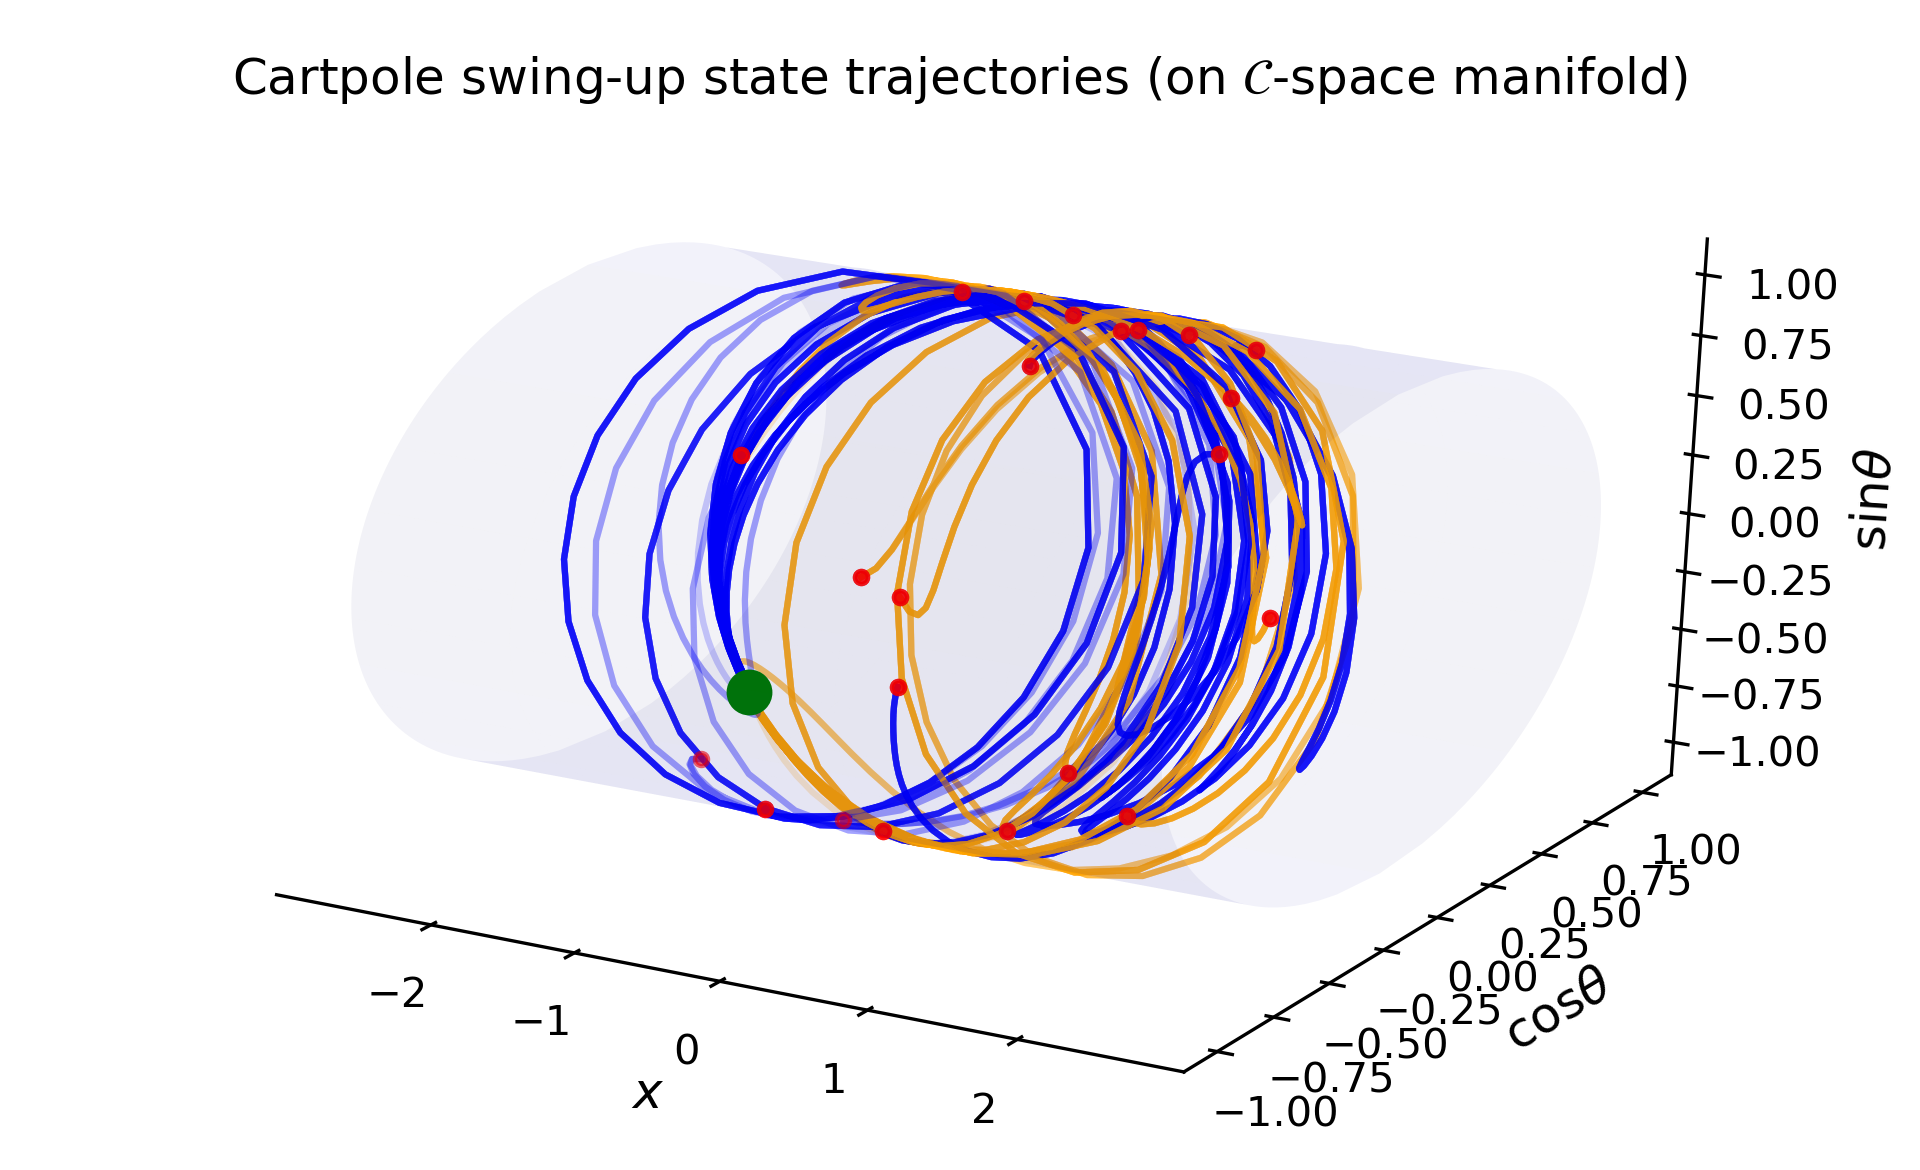

False

In [12]:
fig = plt.figure()
fig.set_size_inches(6.5, 4.0)
fig.set_dpi(300)
ax = fig.add_subplot(111, projection='3d')

plot_x = state_trajectories[:,0]
r = 1. #X_plot[:,3].reshape(sample_dim,time_dim) + 2.
plot_y = r * np.cos(state_trajectories[:,1])
plot_z = r * np.sin(state_trajectories[:,1])

# Cylinder
x=np.linspace(-1, 1, 100)
z=np.linspace(-1, 1, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(1-Xc**2)

# Draw parameters
rstride = 20
cstride = 10
ax.plot_surface(2.7*Zc, Yc, Xc, alpha=0.05, rstride=rstride, cstride=cstride, color='b')
ax.plot_surface(2.7*Zc, -Yc, Xc, alpha=0.05, rstride=rstride, cstride=cstride, color='b')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

class_color = ['orange', 'blue', 'red']

for s in range(sample_dim):
    ax.plot(plot_x[s,:], plot_y[s,:], plot_z[s,:], color=class_color[assigned_class[s]], alpha=0.2)
    ax.scatter(plot_x[s,0], plot_y[s,0], plot_z[s,0], color="r", s=10, alpha=.2)

# Goal on manifold
ax.scatter([0], [-1*r], [0], color="g", s=100, alpha=1.)
 
ax.set_xlabel(r'$x$', fontsize=12)
ax.set_ylabel(r'$\cos\theta$', fontsize=12)
ax.set_zlabel(r'$\sin\theta$', fontsize=12)
plt.title('Cartpole swing-up state trajectories (on $\mathcal{C}$-space manifold)', fontsize=12)

plt.tight_layout()
plt.show()

# fig.subplots_adjust(left=-.12, bottom=0.145, right=.97, top=.99)
fig.subplots_adjust(left=-0.1, bottom=0., right=.98, top=1.02) # for 6.5 x 4

plot_to_pdf and fig.savefig('plot/cartpole_swingup_from_random_state_trajectories_on_manifold_labelled.pdf')

# Labelled state trajectories on manifold for paper

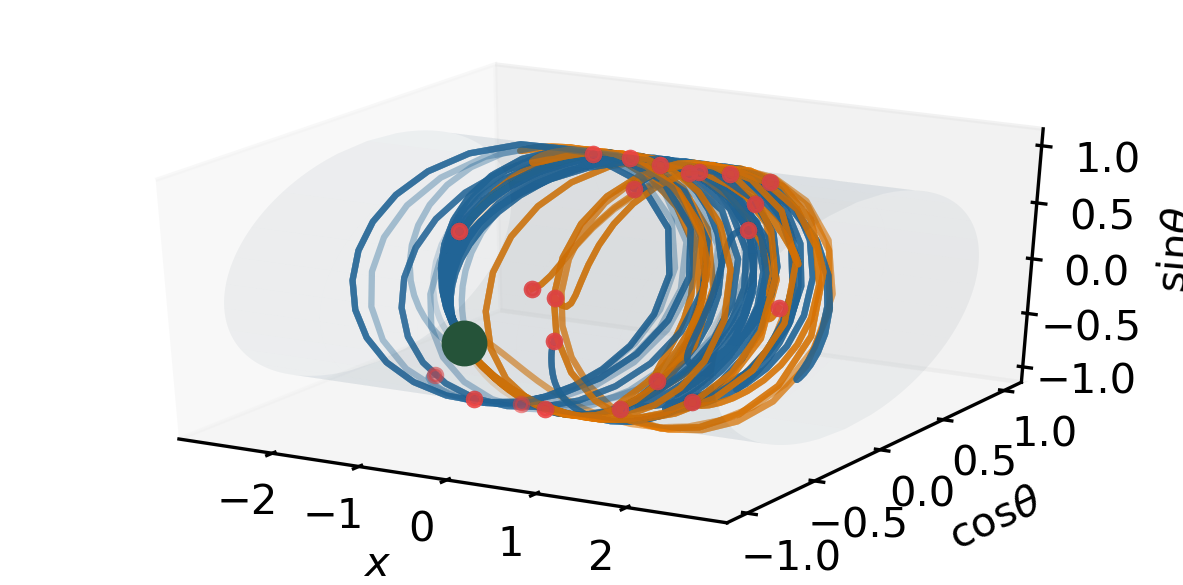

In [13]:
fig = plt.figure()
fig.set_size_inches(3.5, 1.75)
fig.set_dpi(300)
ax = fig.add_subplot(111, projection='3d')

plot_x = state_trajectories[:,0]
r = 1. #X_plot[:,3].reshape(sample_dim,time_dim) + 2.
plot_y = r * np.cos(state_trajectories[:,1])
plot_z = r * np.sin(state_trajectories[:,1])

# Cylinder
x=np.linspace(-1, 1, 100)
z=np.linspace(-1, 1, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(1-Xc**2)

# Draw parameters
rstride = 20
cstride = 10
ax.plot_surface(2.7*Zc, Yc, Xc, alpha=0.05, rstride=rstride, cstride=cstride, color=colors['blue'])
ax.plot_surface(2.7*Zc, -Yc, Xc, alpha=0.05, rstride=rstride, cstride=cstride, color=colors['blue'])

# ax.xaxis.pane.fill = False
# ax.yaxis.pane.fill = False
# ax.zaxis.pane.fill = False
# ax.xaxis.pane.set_edgecolor('w')
# ax.yaxis.pane.set_edgecolor('w')
# ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

#class_color = ['orange', 'blue', 'red']
class_color = [colors['orange'], colors['blue']]

for s in range(sample_dim):
    ax.plot(plot_x[s,:], plot_y[s,:], plot_z[s,:], color=class_color[assigned_class[s]], alpha=0.2)
    ax.scatter(plot_x[s,0], plot_y[s,0], plot_z[s,0], color=colors["red"], s=10, alpha=.2)

# Goal on manifold
ax.scatter([0], [-1*r], [0], color=colors['green'], s=100, alpha=1.)

ax.set_zticks([-1.0, -0.5, 0., 0.5, 1.])
ax.set_yticks([-1.0, -0.5, 0., 0.5, 1.])

ax.xaxis.labelpad = 1
ax.yaxis.labelpad = 1
ax.zaxis.labelpad = -3

ax.xaxis.set_tick_params(pad=0)
ax.yaxis.set_tick_params(pad=0)
ax.zaxis.set_tick_params(pad=0)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\cos\theta$')
ax.set_zlabel(r'$\sin\theta$')

plt.tight_layout()

fig.subplots_adjust(left=-0.11, bottom=0.05, right=.96, top=1.05)

plt.show()

plot_to_pdf and fig.savefig('plot/cartpole_swingup_from_random_state_trajectories_on_manifold_labelled.pdf')

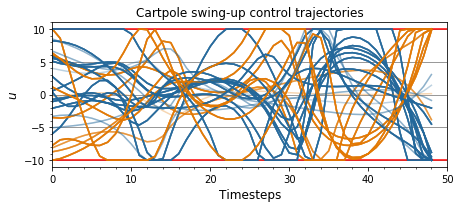

False

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(6.5, 3.0)

ax.hlines(y=10., xmin=0., xmax=time_dim, color='r')
ax.hlines(y=-10., xmin=0., xmax=time_dim, color='r')

for s in range(sample_dim):
    ax.plot(control_trajectories[s,:], color=class_color[assigned_class[s]], alpha=.3)

ax.set_xlabel(r'Timesteps', fontsize=12)
ax.set_ylabel(r'$u$', fontsize=12)
plt.title('Cartpole swing-up control trajectories', fontsize=12)
plt.xlim(0,time_dim)

plt.grid(axis='y', which='major', color='grey', linestyle='-')

plt.minorticks_on()

plt.tight_layout()
plt.show()

fig.subplots_adjust(left=.08, bottom=0.145, right=.97, top=.93)
# fig.subplots_adjust(left=.1, bottom=0.11, right=.98, top=.93)  # for 6.5 x 4

plot_to_pdf and fig.savefig('plot/cartpole_swingup_from_random_control_trajectories_labelled.pdf')

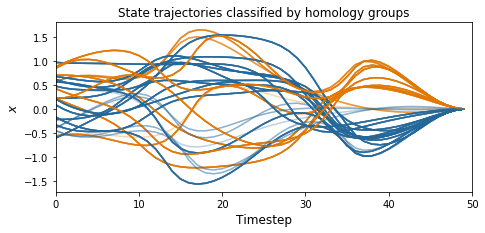

In [15]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
fig.set_size_inches(6.5, 3.0)

for s in range(sample_dim):
    ax.plot(state_trajectories[s,0], color=class_color[assigned_class[s]], alpha=0.3)
    #ax.plot(np.cos(state_trajectories[s,1])+1, color=class_color[assigned_class[s]], alpha=0.3)
    #ax.plot(np.sin(state_trajectories[s,1]), color=class_color[assigned_class[s]], alpha=0.3)

class_color = ['orange', 'blue', 'red']

plt.title('State trajectories classified by homology groups', fontsize=12)
plt.xlabel('Timestep', fontsize=12)
plt.ylabel(r'$x$', fontsize=12)
plt.xlim(0, time_dim)
fig.tight_layout()
fig.subplots_adjust(left=.08, bottom=0.145, right=.97, top=.93)
plot_to_pdf and fig.savefig('plot/cartpole_state_trajectories_x_labelled.pdf')
plt.show()